<a href="https://colab.research.google.com/github/T1M0THY1337/big-data-prediction-challenge/blob/master/prediction_challenge_solution_version_5_resample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction Challange by Sebastian and Tim

Your job is to predict whether or not a person will become a customer of a bank. The data itself contains basic demographic information about numerous  customers as well as data related to phone-based marketing calls during specific campaigns.

# Header

## Version 0.1


---


**2020-01-29** Feature Engineering (Date), Hyperparameter Tuning\
**2020-01-24** Start mit dem Minimum Working Example

## Data Dictionary

<table style="width: 100%;">
    <thead>
        <tr>
            <th style="width: 30%; text-align: left;">Feature</th>
            <th style="width: 70%; text-align: left;">Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>date</td>
            <td>The last contact date</td>
        </tr>
        <tr>
            <td>age</td>
            <td>The age of the customer</td>
        </tr>
        <tr>
            <td>marital_status</td>
            <td>The marital status of the customer</td>
        </tr>
        <tr>
            <td>education</td>
            <td>The educationan of the customer</td>
        </tr>
        <tr>
            <td>job</td>
            <td>The type of job of the customer</td>
        </tr>
        <tr>
            <td>credit_default</td>
            <td>Whether or not the customer has a credit in default</td>
        </tr>
        <tr>
            <td>housing_loan</td>
            <td>Whether or not the customer has a housing loan</td>
        </tr>
        <tr>
            <td>personal_loan</td>
            <td>Whether or not the customer has a personal loan</td>
        </tr>
        <tr>
            <td>communication_type</td>
            <td>The type of contact communication</td>
        </tr>
        <tr>
            <td>n_contacts_campaign</td>
            <td>The number of contacts performed during this marketing campaign and for this customer</td>
        </tr>
        <tr>
            <td>days_since_last_contact</td>
            <td>The number of days passed by after the customer was last contacted from a previous domain</td>
        </tr>
        <tr>
            <td>n_contacts_before</td>
            <td>The number of contacts performed before this marketing campaign and for this customer</td>
        </tr>
        <tr>
            <td>previous_conversion</td>
            <td>Whether or not the customer has been a customer before</td>
        </tr>
        <tr>
            <td>success</td>
            <td>Whether or not the customer became an actual customer (target variable)</td>
        </tr>
    </tbody>   
</table>   

# Programming

## Package Import

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys as sys
import csv, datetime
from datetime import datetime
from scipy.stats import uniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

## Data Import

In [0]:
dataset = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/' +
    'master/datasets/prediction-challenge/dataset.csv', 
    index_col='identifier', parse_dates=['date'])

prediction_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/' +
    'master/datasets/prediction-challenge/prediction-dataset.csv', 
    index_col='identifier', parse_dates=['date'])

## Options

In [0]:
x_random_state = 1909

## Feature Engineering

In [0]:
# Create some new features based on the given features
# or enrich the dataset with features from datasets.

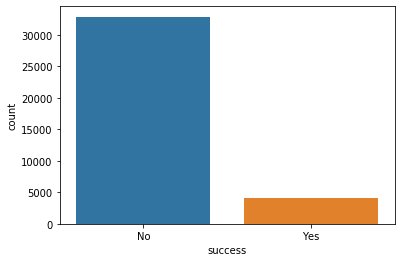

In [67]:
sns.countplot(data=dataset,x="success")

In [0]:
# https://www.kaggle.com/anilkay/handleimbalanceddataclassification

from sklearn.utils import resample

majority=dataset[dataset["success"]=="No"]
minority=dataset[dataset["success"]=="Yes"]

minority_upsampled = resample(minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=15000,    # to match majority class
                                 random_state=x_random_state) # reproducible results
dataset=pd.concat([majority,minority_upsampled])

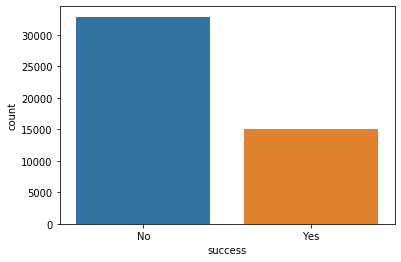

In [69]:
sns.countplot(data=dataset,x="success")

In [0]:
def getYear(inDate):
  return inDate.year
def getMonth(inDate):
  return inDate.month
def getWeekday(inDate):
  return inDate.weekday
def getWeekendDay(inDate):
  if (inDate.weekday == 'Saturday') or (inDate.weekday == 'Sunday'):
    return True
  else:
    return False
def getAgeGroups(inAge):
  if (inAge < 28):
    return 'young'
  elif (49 > inAge > 27):
    return 'younger'
  elif (61 > inAge > 48):
    return 'older'
  else:
    return 'old'

def getDurationGroupsA(inDuration):
  if (inDuration < 250):
    return 'very_short'
  elif (250 < inDuration < 500):
    return 'short'
  elif (500 < inDuration < 750):
    return 'lower_medium'
  elif (750 < inDuration < 1000):
    return 'medium'
  elif (1000 < inDuration < 1250):
    return 'higher_medium'
  elif (1250 < inDuration < 1500):
    return 'long'
  elif (1500 < inDuration < 1750):
    return 'very_long'
  else:
    return 'very_big_call'

def getDurationGroupsB(inDuration):
  if (inDuration < 250):
    return 0
  elif (250 < inDuration < 500):
    return 1
  elif (500 < inDuration < 750):
    return 2
  elif (750 < inDuration < 1000):
    return 3
  elif (1000 < inDuration < 1250):
    return 4
  elif (1250 < inDuration < 1500):
    return 5
  elif (1500 < inDuration < 1750):
    return 6
  else:
    return 7

def getSeasons(inMonth):
  if(3 < inMonth < 6):
    return 'spring'
  if(5 < inMonth < 9):
    return 'summer'
  if(8 < inMonth < 12):
    return 'fall'
  else:
    return 'winter'

dataset['date'] = pd.to_datetime(dataset['date'])
dataset.insert(1, "dateYear", dataset['date'], allow_duplicates=True)
dataset.insert(2, "dateMonth", dataset['date'], allow_duplicates=True)
dataset.insert(3, "dateWeekday", dataset['date'], allow_duplicates=True)
dataset.insert(4, "dateWeekendDay", dataset['date'], allow_duplicates=True)

dataset.insert(6, "ageGroups", dataset['age'], allow_duplicates=True)
dataset.insert(19, "durationGroups", dataset['duration'], allow_duplicates=True)

# dataset.dateYear = dataset.dateYear.apply(getYear)
# dataset.dateMonth = dataset.dateMonth.apply(getMonth)

dataset.dateYear = dataset['dateYear'].dt.year
dataset.dateMonth = dataset['dateMonth'].dt.month
dataset.dateWeekday = dataset['dateWeekday'].dt.weekday_name
dataset.dateWeekendDay = dataset.dateWeekendDay.apply(getWeekendDay)
dataset.ageGroups = dataset.ageGroups.apply(getAgeGroups)
dataset.durationGroups = dataset.durationGroups.apply(getDurationGroupsA)

dataset.insert(5, "dateSeason", dataset['dateMonth'], allow_duplicates=True)
dataset.dateSeason = dataset.dateSeason.apply(getSeasons)

In [71]:
dataset.head(1)

,date,dateYear,dateMonth,dateWeekday,dateWeekendDay,dateSeason,age,ageGroups,marital_status,education,job,credit_default,housing_loan,personal_loan,communication_type,n_contacts_campaign,days_since_last_contact,n_contacts_before,previous_conversion,duration,durationGroups,success
identifier,,,,,,,,,,,,,,,,,,,,,,
34203,2009-05-06,2009,5,Wednesday,False,spring,36,younger,divorced,High School,Service provider,No,No,Yes,Landline network,5,-1,0,Inexistent,992,medium,No


## Model, Pipeline and Scoring Initialization

In [0]:
# dataset[['date', 'age', 'marital_status', 'education', 'job', 'credit_default', 'housing_loan', 'personal_loan', 'communication_type', 'n_contacts_campaign', 'days_since_last_contact', 'n_contacts_before', 'previous_conversion', 'duration']]

X = dataset[['dateYear', 'dateMonth', 'dateWeekday', 'dateSeason', 'ageGroups', 'marital_status', 'education', 'job', 'credit_default', 'housing_loan', 'personal_loan', 'communication_type', 'n_contacts_campaign', 'days_since_last_contact', 'n_contacts_before', 'previous_conversion', 'duration', 'durationGroups']]
y = dataset['success']

## Handle Imbalanced Dataset
with Parameter fpr xgboost: scale_pos_weight

In [73]:
ratio = float(np.sum(y == "No")) / np.sum(y == "Yes")
ratio

2.1928666666666667

In [0]:
# xgb.XGBClassifier?

In [0]:
classifier = xgb.XGBClassifier(n_jobs=-1, random_state=x_random_state, objective='binary:logistic', scale_pos_weight=ratio)

In [0]:
x_rscv = StratifiedKFold(n_splits=5, shuffle=True, random_state=x_random_state)
x_rscv = x_rscv.split(X, y)

In [0]:
#scorer = make_scorer(f1_score, pos_label='Yes')

recall_scorer = make_scorer(recall_score, average='binary', pos_label='Yes')
f1_scorer = make_scorer(f1_score, average='binary', pos_label='Yes')

In [0]:
numeric_features = ['n_contacts_campaign', 'days_since_last_contact', 'n_contacts_before', 'duration']
numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler()),
])

categorical_features = ['dateYear', 'dateMonth', 'dateWeekday', 'dateSeason', 'ageGroups', 'marital_status', 'education', 'job', 'credit_default', 'housing_loan', 'personal_loan', 'communication_type', 'previous_conversion', 'durationGroups']
categorical_transformer = Pipeline([
    ('onehotencoder', OneHotEncoder(drop='first')),
])

preprocessor = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, numeric_features),
    ('categorical_transformer', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [0]:
param_distributions = {
                        "classifier__learning_rate": uniform.rvs(0.0001, 0.1, size=20),
                        "classifier__gamma" : uniform.rvs(0, 2, size=20),
                        "classifier__max_depth": randint.rvs(2, 100, size=20),
                        "classifier__colsample_bytree": uniform.rvs(0.1, 0.9, size=20),
                        "classifier__subsample": uniform.rvs(0.1, 0.9, size=20),
                        "classifier__reg_alpha": uniform.rvs(0, 0.9, size=20),
                        "classifier__reg_lambda": uniform.rvs(0.0001, 5, size=20),
                        "classifier__min_child_weight": randint.rvs(1, 7, size=20),
                        "classifier__n_estimators": randint.rvs(100, 1000, size=20)
                      }

In [0]:
search = RandomizedSearchCV(
    pipeline, param_distributions=param_distributions, n_iter=10, scoring={'recall_score': recall_scorer, 'f1_score': f1_scorer, 'AUC': 'roc_auc'}, 
    n_jobs=-1, cv=x_rscv, random_state=x_random_state, refit='recall_score', return_train_score=True)

In [0]:
search = search.fit(X, y)

In [82]:
search.cv_results_

{'mean_fit_time': array([  8.72622619, 118.83883801,   8.45440593,  61.37715654,
         40.02890368,  32.93415647,  20.77072568,  15.96230493,
         64.75027528,  86.17803445]),
 'mean_score_time': array([0.90630059, 6.97272072, 0.8840723 , 3.93803   , 3.57120805,
        2.14082327, 1.39896731, 1.17013283, 4.08039694, 3.8323566 ]),
 'mean_test_AUC': array([0.9528007 , 0.98475951, 0.94176612, 0.98231086, 0.96267502,
        0.97256295, 0.97860368, 0.95539566, 0.98368838, 0.98817513]),
 'mean_test_f1_score': array([0.83252435, 0.90829993, 0.8116179 , 0.90465773, 0.86386478,
        0.88706837, 0.89329117, 0.84161244, 0.90828302, 0.91553225]),
 'mean_test_recall_score': array([0.93726667, 0.98153333, 0.91726667, 0.98266667, 0.9552    ,
        0.96973333, 0.97413333, 0.9378    , 0.9824    , 0.982     ]),
 'mean_train_AUC': array([0.96025875, 0.99977984, 0.94357919, 0.9993541 , 0.97949977,
        0.99428705, 0.99632361, 0.96542567, 0.99980636, 0.99999933]),
 'mean_train_f1_score': a

In [83]:
f'Optimal parameters: {search.best_params_}'

"Optimal parameters: {'classifier__subsample': 0.8298951492918261, 'classifier__reg_lambda': 3.3281957219036458, 'classifier__reg_alpha': 0.5238945533823781, 'classifier__n_estimators': 518, 'classifier__min_child_weight': 5, 'classifier__max_depth': 63, 'classifier__learning_rate': 0.041207625579580034, 'classifier__gamma': 0.5221927921022986, 'classifier__colsample_bytree': 0.5226075917234883}"

## Evaluation

In [0]:
training_score = search.cv_results_['mean_train_f1_score'][search.best_index_] * 100
test_score = search.cv_results_['mean_test_f1_score'][search.best_index_] * 100

In [85]:
f'Mean F1 Score (Training/Test): {training_score:.2f}%/{test_score:.2f}%'

'Mean F1 Score (Training/Test): 96.31%/90.47%'

In [0]:
training_score = search.cv_results_['mean_train_recall_score'][search.best_index_] * 100
test_score = search.cv_results_['mean_test_recall_score'][search.best_index_] * 100

In [87]:
f'Mean Recall Score (Training/Test): {training_score:.2f}%/{test_score:.2f}%'

'Mean Recall Score (Training/Test): 99.85%/98.27%'

In [0]:
training_score = search.cv_results_['mean_train_AUC'][search.best_index_] * 100
test_score = search.cv_results_['mean_test_AUC'][search.best_index_] * 100

In [89]:
f'Mean AUC Score (Training/Test): {training_score:.2f}%/{test_score:.2f}%'

'Mean AUC Score (Training/Test): 99.94%/98.23%'

In [90]:
mean_fit_time = search.cv_results_['mean_fit_time'][search.best_index_]
mean_score_time = search.cv_results_['mean_score_time'][search.best_index_]
f'Mean mean_fit_time / mean_score_time: {mean_fit_time:.2f}/{mean_score_time:.2f}'

'Mean mean_fit_time / mean_score_time: 61.38/3.94'

## Log Datei füttern

In [91]:
# datetime;alpha;lambda;random_state;n_estimators_min;n_estimators_max;max_depth_min;x_max_depth_max;best_n_estimators;best_max_depth;best_learning_rate;f1_training;f1_test;std_train_score;std_test_score

logData = [[datetime.now()
            ,search.best_params_['classifier__learning_rate']
            ,search.best_params_['classifier__gamma']
            ,search.best_params_['classifier__max_depth']
            ,search.best_params_['classifier__colsample_bytree']
            ,search.best_params_['classifier__subsample']
            ,search.best_params_['classifier__reg_alpha']
            ,search.best_params_['classifier__reg_lambda']
            ,search.best_params_['classifier__min_child_weight']
            ,search.best_params_['classifier__n_estimators']
            ,training_score
            ,test_score
            ,search.cv_results_['std_train_score'][search.best_index_]
            ,search.cv_results_['std_test_score'][search.best_index_]]]
with open('log2.csv', 'a') as csvfile:
  writer = csv.writer(csvfile, delimiter=';')
  writer.writerows(logData)

KeyError: ignored

## Prediction

In [0]:
sys.exit()
predictions = search.best_estimator_.predict(prediction_dataset)

## Submission Dataset Preparation

Your upload to the Online-Campus should contain your written report (the actual seminar paper), this notebook as file as well as the generated submission dataset with your predictions.

In [0]:
submission = pd.DataFrame(
    predictions, index=prediction_dataset.index, columns=['prediction'])

In [0]:
matriculation_number = '12345678'

In [0]:
submission.to_csv(
    f'./submission-{matriculation_number}.csv', index_label='identifier')

# Nützliche Links
* XGboost Implementation: [https://www.datacamp.com/community/tutorials/xgboost-in-python](https://www.datacamp.com/community/tutorials/xgboost-in-python)
* XGBoost Parameter List: [https://xgboost.readthedocs.io/en/latest/parameter.html](https://xgboost.readthedocs.io/en/latest/parameter.html)
* XGBoost Tuning Parameters: [https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/](https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/)